## 01_ETL

This stage involves the data initial exploration and transformation of the three main datasets:
steam_games, australian_users_reviews, and australian_users_items, for subsequent analysis and the development of recommendation systems.

In [1]:
import ast
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from datetime import datetime
from lib import personalised_graphics, transformations

##### steam_games

Import

In [2]:
# Import dataset
steam_games = pd.read_json('data/unprocessed/output_steam_games.json', lines=True)
steam_games = steam_games.dropna(how='all')

# Reorder columns
steam_games = steam_games[['id', 'release_date', "early_access", 'app_name', "title", 'price', 'publisher', 'developer', "genres", 'tags', 'specs', "url", "reviews_url"]]
steam_games

,id,release_date,early_access,app_name,title,price,publisher,developer,genres,tags,specs,url,reviews_url
88310,761140.0,2018-01-04,0.0,Lost Summoner Kitty,Lost Summoner Kitty,4.99,Kotoshiro,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]","[Strategy, Action, Indie, Casual, Simulation]",[Single-player],http://store.steampowered.com/app/761140/Lost_...,http://steamcommunity.com/app/761140/reviews/?...
88311,643980.0,2018-01-04,0.0,Ironbound,Ironbound,Free To Play,"Making Fun, Inc.",Secret Level SRL,"[Free to Play, Indie, RPG, Strategy]","[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",http://store.steampowered.com/app/643980/Ironb...,http://steamcommunity.com/app/643980/reviews/?...
88312,670290.0,2017-07-24,0.0,Real Pool 3D - Poolians,Real Pool 3D - Poolians,Free to Play,Poolians.com,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]","[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",http://store.steampowered.com/app/670290/Real_...,http://steamcommunity.com/app/670290/reviews/?...
88313,767400.0,2017-12-07,0.0,弹炸人2222,弹炸人2222,0.99,彼岸领域,彼岸领域,"[Action, Adventure, Casual]","[Action, Adventure, Casual]",[Single-player],http://store.steampowered.com/app/767400/2222/,http://steamcommunity.com/app/767400/reviews/?...
88314,773570.0,None,0.0,Log Challenge,None,2.99,None,None,None,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",http://store.steampowered.com/app/773570/Log_C...,http://steamcommunity.com/app/773570/reviews/?...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120440,773640.0,2018-01-04,0.0,Colony On Mars,Colony On Mars,1.99,Ghost_RUS Games,"Nikita ""Ghost_RUS""","[Casual, Indie, Simulation, Strategy]","[Strategy, Indie, Casual, Simulation]","[Single-player, Steam Achievements]",http://store.steampowered.com/app/773640/Colon...,http://steamcommunity.com/app/773640/reviews/?...
120441,733530.0,2018-01-04,0.0,LOGistICAL: South Africa,LOGistICAL: South Africa,4.99,Sacada,Sacada,"[Casual, Indie, Strategy]","[Strategy, Indie, Casual]","[Single-player, Steam Achievements, Steam Clou...",http://store.steampowered.com/app/733530/LOGis...,http://steamcommunity.com/app/733530/reviews/?...
120442,610660.0,2018-01-04,0.0,Russian Roads,Russian Roads,1.99,Laush Studio,Laush Dmitriy Sergeevich,"[Indie, Racing, Simulation]","[Indie, Simulation, Racing]","[Single-player, Steam Achievements, Steam Trad...",http://store.steampowered.com/app/610660/Russi...,http://steamcommunity.com/app/610660/reviews/?...
120443,658870.0,2017-09-02,0.0,EXIT 2 - Directions,EXIT 2 - Directions,4.99,SIXNAILS,"xropi,stev3ns","[Casual, Indie]","[Indie, Casual, Puzzle, Singleplayer, Atmosphe...","[Single-player, Steam Achievements, Steam Cloud]",http://store.steampowered.com/app/658870/EXIT_...,http://steamcommunity.com/app/658870/reviews/?...


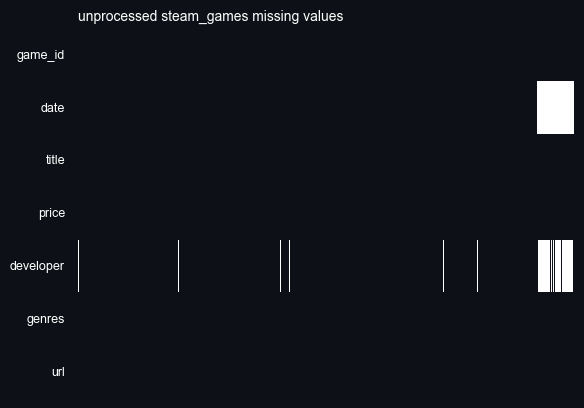

In [28]:
# Explore missing values
personalised_graphics.missing_values_heatmap(steam_games, "unprocessed steam_games")

Transform

In [4]:
# Handle genres repetitive data
genres = []
for i, row in steam_games.iterrows():
    if row["tags"] == None and row["genres"] != None:
        genres.append(row["genres"])
    else:
        genres.append(row["tags"])
steam_games["tags"] = genres
steam_games.drop(columns=['genres'], inplace=True)

In [5]:
# Handle missing values
steam_games["price"].fillna(0, inplace=True)
steam_games["tags"].fillna("[]", inplace=True)
steam_games.at[90890, "app_name"] = "Duet"
steam_games.dropna(subset=["app_name"], inplace=True)

In [6]:
# Handle wrong datatypes

# price
steam_games["int_price"] = 0
errors = []
for i, row in steam_games.iterrows():
    try:
        row["int_price"] = float(row["price"])
    except ValueError:
        errors.append(row["price"])
errors = [value for value in set(errors)]
steam_games["price"].replace("Starting at $499.00", 500, inplace=True)
errors.remove("Starting at $499.00")
steam_games["price"].replace("Starting at $449.00", 450, inplace=True)
errors.remove("Starting at $449.00")
for error in errors:
    steam_games["price"].replace(error, 0, inplace=True)
steam_games['price'] = steam_games['price'].astype(float)
steam_games.drop(columns=["int_price"], inplace=True)

# date
steam_games['release_date'] = pd.to_datetime(steam_games['release_date'], errors='coerce')

In [7]:
# Handle irelevant data
steam_games.drop(columns=['early_access', 'reviews_url', 'publisher', 'specs', 'title'], inplace=True)
mask = steam_games['tags'].apply(lambda genres: 'Movie' not in genres and 'Documentary' not in genres)
steam_games = steam_games[mask]

In [8]:
# Restructure dataframe
steam_games.rename(columns={"id": "game_id", "release_date": "date", "app_name": "title", "tags": "genres"}, inplace=True)
steam_games = steam_games.sort_values(by='date')
steam_games = steam_games.reset_index(drop=True)
steam_games

C:\Users\david\AppData\Local\Temp\ipykernel_11424\3581512276.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steam_games.rename(columns={"id": "game_id", "release_date": "date", "app_name": "title", "tags": "genres"}, inplace=True)


,game_id,date,title,price,developer,genres,url
0,227380.0,1983-06-19,Dragon's Lair,9.99,Digital Leisure Inc.,"[Adventure, Action, FMV, Casual, Quick-Time Ev...",http://store.steampowered.com/app/227380/Drago...
1,240340.0,1984-04-29,Space Ace,9.99,Digital Leisure Inc.,"[Adventure, Casual, Action, Quick-Time Events,...",http://store.steampowered.com/app/240340/Space...
2,517930.0,1984-11-01,The Castles of Dr. Creep,1.99,"Ed Hobbs,Robert Crossfield","[Casual, Indie, Puzzle-Platformer, Retro, Puzz...",http://store.steampowered.com/app/517930/The_C...
3,329660.0,1985-01-01,Silent Service,6.99,"MicroProse Software, Inc","[Simulation, Classic]",http://store.steampowered.com/app/329660/Silen...
4,664780.0,1986-05-01,Alter Ego,7.99,Choose Multiple LLC,"[RPG, Casual, Indie, Adventure, Simulation, Te...",http://store.steampowered.com/app/664780/Alter...
...,...,...,...,...,...,...,...
31332,755830.0,NaT,Lonely Astronaut,0.00,"Greyson Richey,Nicholas Lives","[Casual, Action, Indie, Simulation]",http://store.steampowered.com/app/755830/Lonel...
31333,708070.0,NaT,RECHARGE COMPLETE,0.00,rechargecomplete,"[Early Access, Action, Adventure, Indie]",http://store.steampowered.com/app/708070/RECHA...
31334,250440.0,NaT,Tetrapulse,0.00,The Amiable,"[Indie, Action, Co-op]",http://store.steampowered.com/app/250440/Tetra...
31335,772180.0,NaT,Cricket Club,0.00,VersoVR,"[Early Access, Indie, Casual, Simulation, Sports]",http://store.steampowered.com/app/772180/Crick...


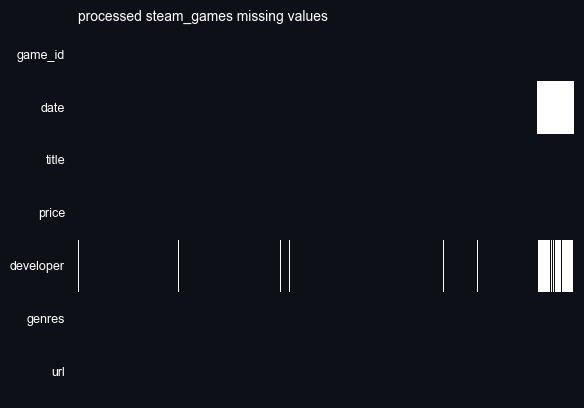

In [9]:
# Explore missing values
personalised_graphics.missing_values_heatmap(steam_games, "processed steam_games")

##### australian_users_reviews dataset

Import

In [12]:
# Import dataset
users_reviews = pd.read_parquet("data/unprocessed/users_reviews.parquet")
# Desanidate columns
reviews = []
for index, row in users_reviews.iterrows():
    user_id = row['user_id']
    reviews_list = row['reviews']
    for review_dict in reviews_list:
        funny = review_dict['funny']
        posted = review_dict['posted']
        last_edited = review_dict['last_edited']
        item_id = review_dict['item_id']
        helpful = review_dict['helpful']
        recommend = review_dict['recommend']
        review = review_dict['review']
        if not funny:
            funny = None
        if not posted:
            posted = None
        if not last_edited:
            last_edited = None
        if not item_id:
            item_id = None
        if not helpful:
            helpful = None
        if not recommend:
            recommend = None
        if not review:
            review = None
        reviews.append({'user_id': user_id, 'funny': funny, 'posted': posted, 'last_edited': last_edited, 'item_id': item_id, 'helpful': helpful, 'recommend': recommend, 'review': review})
users_reviews = pd.DataFrame(reviews)
users_reviews.head(5)

,user_id,funny,posted,last_edited,item_id,helpful,recommend,review
0,76561197970982479,None,"Posted November 5, 2011.",None,1250,No ratings yet,True,Simple yet with great replayability. In my opi...
1,76561197970982479,None,"Posted July 15, 2011.",None,22200,No ratings yet,True,It's unique and worth a playthrough.
2,76561197970982479,None,"Posted April 21, 2011.",None,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...
3,js41637,None,"Posted June 24, 2014.",None,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...
4,js41637,None,"Posted September 8, 2013.",None,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...


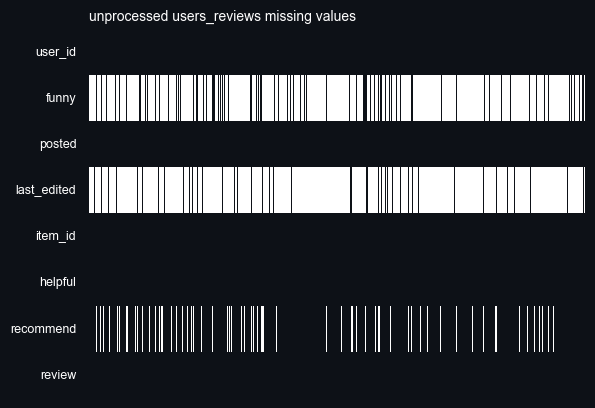

In [13]:
# Explore missing values
personalised_graphics.missing_values_heatmap(users_reviews, "unprocessed users_reviews")

Transform

In [14]:
# Handle date repetitive data
for index, row in users_reviews.iterrows():
    posted_date = row['posted']
    last_edited_date = row['last_edited']
    # Unificate posted and last edited column
    if last_edited_date is not None and (posted_date is None or last_edited_date > posted_date):
        users_reviews.at[index, 'posted'] = row['last_edited']
users_reviews.drop(columns=["last_edited"], inplace=True)
users_reviews.rename(columns={"posted": "date"}, inplace=True)

In [15]:
# Handle wrong datatypes

# date
for index, row in users_reviews.iterrows():
    date_str = row['date']
    date_str = date_str.replace("Posted ", "")
    date_str = date_str.replace(".", "")
    date_str = date_str.replace(",", "")
    date_parts = date_str.split()
    if len(date_parts) == 3:
        date_obj = datetime(int(date_parts[2]), datetime.strptime(date_parts[0], '%B').month, int(date_parts[1]))
    users_reviews.at[index, 'date'] = date_obj

In [16]:
# Create sentimment review column
users_reviews["sentiment"] = None
for index, row in users_reviews.iterrows():
    review = row['review']
    sentiment = transformations.return_sentiment(review) # This function takes a review in string format and return 2 (good), 1 (neutral), 0 (bad)
    users_reviews.at[index, 'sentiment'] = sentiment

In [17]:
# Proces helpful column
for i, row in users_reviews.iterrows():
    if row["helpful"] == "No ratings yet":
        users_reviews.at[i, "helpful"] = 50
    else:
        try:
            parts = row["helpful"].split(" ")
            score = parts[4].replace("%", "").replace("(", "").replace(")", "")
            users_reviews.at[i, "helpful"] = int(score)  # Convert the score to an integer if needed
        except IndexError:
            pass

In [18]:
# Drop irrelevant data columns
users_reviews.drop(columns=["funny"], inplace=True)

# Rename columns
users_reviews.rename(columns={"item_id": "game_id"}, inplace=True)
users_reviews["game_id"] = users_reviews["game_id"].astype(int)

users_reviews.head(5)

,user_id,date,game_id,helpful,recommend,review,sentiment
0,76561197970982479,2011-11-05 00:00:00,1250,50,True,Simple yet with great replayability. In my opi...,1
1,76561197970982479,2011-07-15 00:00:00,22200,50,True,It's unique and worth a playthrough.,2
2,76561197970982479,2011-04-21 00:00:00,43110,50,True,Great atmosphere. The gunplay can be a bit chu...,1
3,js41637,2014-06-24 00:00:00,251610,75,True,I know what you think when you see this title ...,1
4,js41637,2013-09-08 00:00:00,227300,0,True,For a simple (it's actually not all that simpl...,1


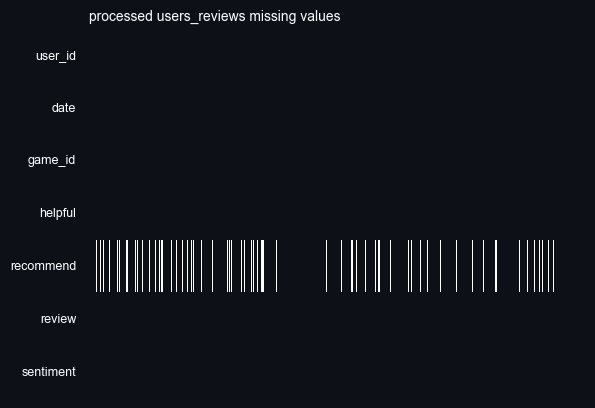

In [19]:
# Explore missing values
personalised_graphics.missing_values_heatmap(users_reviews, "processed users_reviews")

##### australian_users_items dataset

Import

In [22]:
# Import dataset
users_items = pd.read_parquet("data/unprocessed/users_items.parquet")
# Desanidate column
items = []
for index, row in users_items.iterrows():
    user_id = row['user_id']
    user_url = row['user_url']
    item_list = row['items']
    for item_dict in item_list:
        item_id = item_dict['item_id']
        item_name = item_dict['item_name']
        playtime_forever = item_dict['playtime_forever']
        playtime_2weeks = item_dict['playtime_2weeks']
        if not item_id:
            item_id = None
        if not item_name:
            item_name = None
        if not playtime_forever:
            playtime_forever = 0
        if not playtime_2weeks:
            playtime_2weeks = 0
        items.append({'user_id': user_id, 'user_url': user_url, 'id': item_id, 'item_name': item_name, 'playtime_forever': playtime_forever, 'playtime_2weeks': playtime_2weeks})
users_items = pd.DataFrame(items)
users_items

,user_id,user_url,id,item_name,playtime_forever,playtime_2weeks
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,10,Counter-Strike,6,0
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,20,Team Fortress Classic,0,0
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,30,Day of Defeat,7,0
3,76561197970982479,http://steamcommunity.com/profiles/76561197970...,40,Deathmatch Classic,0,0
4,76561197970982479,http://steamcommunity.com/profiles/76561197970...,50,Half-Life: Opposing Force,0,0
...,...,...,...,...,...,...
5153204,76561198329548331,http://steamcommunity.com/profiles/76561198329...,346330,BrainBread 2,0,0
5153205,76561198329548331,http://steamcommunity.com/profiles/76561198329...,373330,All Is Dust,0,0
5153206,76561198329548331,http://steamcommunity.com/profiles/76561198329...,388490,One Way To Die: Steam Edition,3,3
5153207,76561198329548331,http://steamcommunity.com/profiles/76561198329...,521570,You Have 10 Seconds 2,4,4


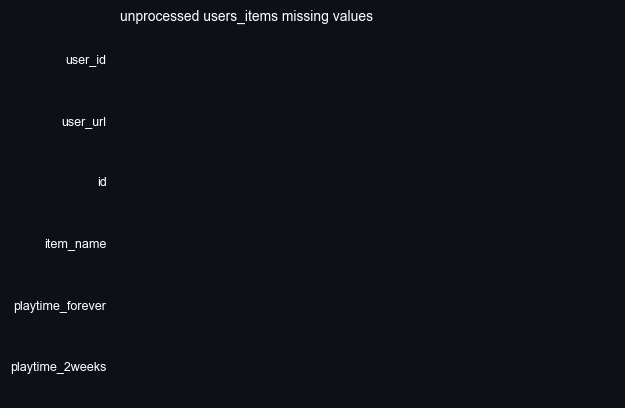

In [23]:
# Explore missing values
personalised_graphics.missing_values_heatmap(users_items, "unprocessed users_items")

Transform and explore

In [24]:
# Rename colums
users_items.rename(columns={"id": "game_id"}, inplace=True)

# Drop unrelevant data
users_items.drop(columns=["user_url", "item_name"], inplace=True)

# Handle wrong datatypes
#users_items["user_id"] = users_items["user_id"].astype(int)
users_items["game_id"] = users_items["game_id"].astype(int)
users_items["playtime_forever"] = users_items["playtime_forever"].astype(int)
users_items["playtime_2weeks"] = users_items["playtime_2weeks"].astype(int)

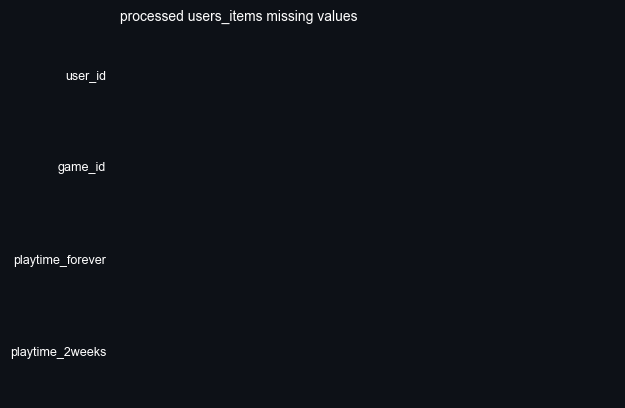

In [37]:
# Explore
personalised_graphics.missing_values_heatmap(users_items, "processed users_items")

CREATION

After transformig the users_reviews and users_items datasets, I calculate some complementary information for each game, which will help to evaluate the success of each game between the users:

In [29]:
# Create a score value for each game
users_reviews["score"] = users_reviews["sentiment"] * users_reviews["helpful"] * 2 / 100
scores = users_reviews.groupby("game_id")["score"].mean()
scores = scores.to_frame().reset_index()
scores.columns = ["game_id", "score"]
steam_games = pd.merge(steam_games, scores, on="game_id", how="left")

In [30]:
# Calculate the total playtime for each game
item_total_playtimes = users_items.groupby("game_id")["playtime_forever"].sum()
item_total_playtimes = item_total_playtimes.to_frame().reset_index()
item_total_playtimes["game_id"] = item_total_playtimes["game_id"].astype(int)
steam_games = pd.merge(steam_games, item_total_playtimes, on="game_id", how="left")

In [31]:
# Calculate the las 2 weeks playtime for each game
item2week_playtimes = users_items.groupby("game_id")["playtime_2weeks"].sum()
item2week_playtimes = item2week_playtimes.to_frame().reset_index()
item2week_playtimes["game_id"] = item2week_playtimes["game_id"].astype(int)
steam_games = pd.merge(steam_games, item2week_playtimes, on="game_id", how="left")

In [32]:
# Calculate the amount of downloads for each game
item_total_downloads = users_items["game_id"].value_counts()
item_total_downloads = item_total_downloads.to_frame().reset_index()
item_total_downloads.columns = ["game_id", "downloads"]
item_total_downloads["game_id"] = item_total_downloads["game_id"].astype(int)
steam_games = pd.merge(steam_games, item_total_downloads, on="game_id", how="left")

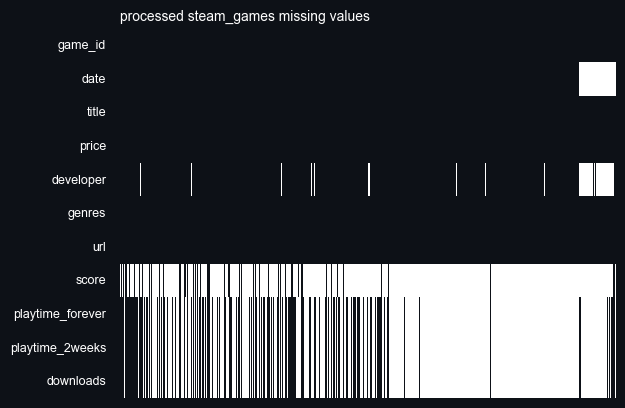

In [34]:
personalised_graphics.missing_values_heatmap(steam_games, "processed steam_games")

Export data

In [38]:
steam_games.to_csv("data/steam_games.csv")

table_users_reviews = pa.Table.from_pandas(users_reviews)
pq.write_table(table_users_reviews, 'data/users_reviews.parquet')

table_users_items = pa.Table.from_pandas(users_items)
pq.write_table(table_users_items, 'data/users_items.parquet')

RESUME

In [42]:
from PIL import Image
import os

image_paths = [
    "gallery/ETL/unprocessed steam_games.png",
    "gallery/ETL/unprocessed users_reviews.png",
    "gallery/ETL/unprocessed users_items.png",
    "gallery/ETL/processed steam_games.png",
    "gallery/ETL/processed users_reviews.png",
    "gallery/ETL/processed users_items.png",
]

# Abre las 6 imágenes y las almacena en una lista
images = [Image.open(image_path) for image_path in image_paths]

# Asegúrate de que las imágenes tengan el mismo tamaño (ajusta según sea necesario)
width, height = images[0].size
for img in images:
    img.thumbnail((width, height))

# Crea una nueva imagen para la grilla con un fondo personalizado
space_color = (13, 17, 23)  # RGB correspondiente a #0D1117
grid_image = Image.new("RGB", (width * 3, height * 2), space_color)

# Organiza las imágenes en la grilla
for i in range(6):
    row = i // 3
    col = i % 3
    grid_image.paste(images[i], (col * width, row * height))

# Guarda la grilla en un archivo
grid_image.save("gallery/ETL/ETL.jpg")

# Muestra la grilla
grid_image.show()
